# Bayes - Regresion Lineal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

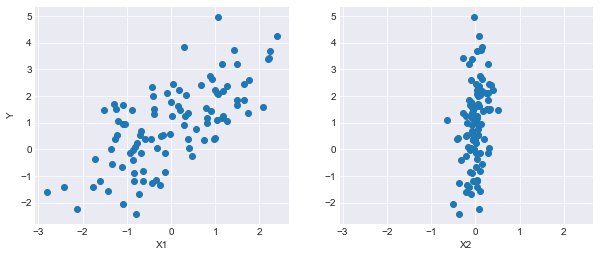

In [2]:

%matplotlib inline

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

In [4]:
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\users\jair\appdata\local\programs\python\python36\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


In [4]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

 Maximum a posteriori

In [5]:
map_estimate = pm.find_MAP(model=basic_model)

map_estimate

c:\users\jair\appdata\local\programs\python\python36\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -149.58, ||grad|| = 12.242: 100%|███████████████████████████████████████████████| 19/19 [00:00<00:00, 62.25it/s]


{'alpha': array(0.90660093),
 'beta': array([0.94848596, 2.60711845]),
 'sigma_log__': array(-0.03771373),
 'sigma': array(0.96298858)}

In [6]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(10,cores=1,random_seed = 123)

Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:49<00:00, 10.30it/s]
c:\users\jair\appdata\local\programs\python\python36\lib\site-packages\pymc3\sampling.py:464: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


In [7]:
trace['alpha'][-5:]

array([0.93537771, 0.92931339, 0.87655458, 0.78913743, 1.0945068 ])

In [ ]:
with basic_model:

    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step, cores =  1, random_seed = 123)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]


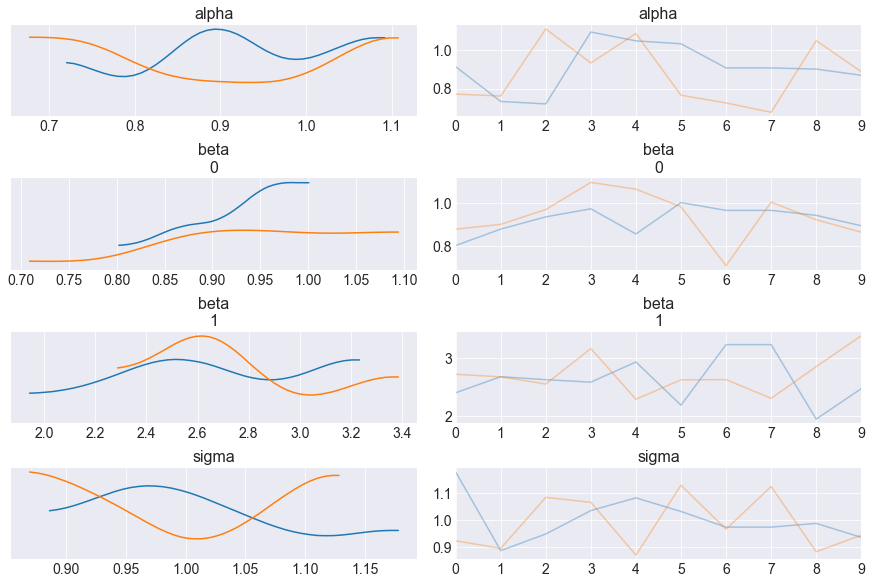

In [8]:
pm.traceplot(trace);

In [8]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.91,0.12,0.01,0.71,1.18,-88.88,0.95
beta__0,0.95,0.08,0.02,0.80,1.18,18.99,1.00
beta__1,2.47,0.47,0.11,1.18,3.32,10.30,1.05
sigma,1.00,0.08,0.01,0.87,1.12,82.47,0.99


# A joke model

In [11]:
RATINGS = [4,4,3,4]

In [12]:
with pm.Model() as joke_model:
    mu = pm.Uniform('mu',lower = 1 , upper = 10)
    sd = pm.HalfCauchy('sd',beta=10) #(Theta)
    obs = pm.TruncatedNormal(
        'obs',
        mu= mu,
        sd = sd,
        lower = 1,
        upper = 10,
        observed = RATINGS
    ) #(Data/Theta)

In [13]:
map_estimate = pm.find_MAP(model= joke_model)

logp = -7.8446, ||grad|| = 2.4485: 100%|███████████████████████████████████████████████| 19/19 [00:00<00:00, 53.07it/s]


In [14]:
with joke_model:
    start = map_estimate
    step= pm.Metropolis()
    traces = pm.sample(50000,step=step, start = start,cores= 1)


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sd]
>Metropolis: [mu]
100%|████████████████████████████████████████████████████████████████████████████| 50500/50500 [19:15<00:00, 43.70it/s]
The number of effective samples is smaller than 10% for some parameters.


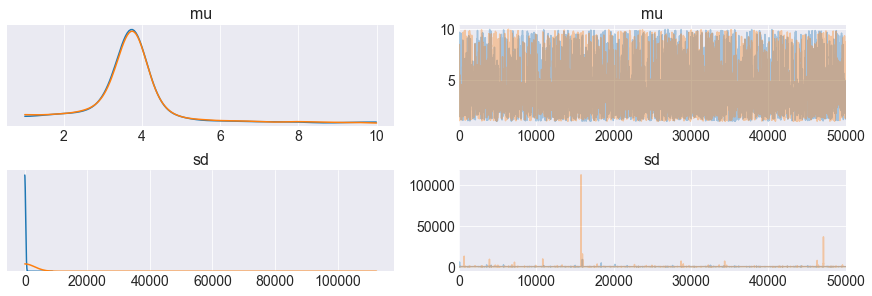

In [20]:
pm.traceplot(traces); #(Theta/Data)

In [23]:
revision= pm.trace_to_dataframe(traces).tail(5000) # More quickly

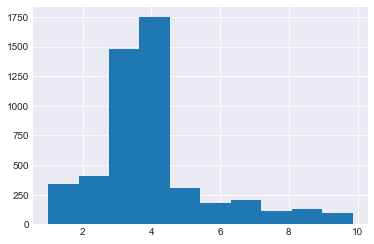

In [26]:
revision.mu.hist()

# Charge  Coin Detector

We have a strong belive that this coin is fair 

In [5]:
TRIALS = [0,1,1,0,1,1,1,0,1,0,1,1]

In [6]:
with pm.Model() as success_model:
    #p_success = pm.Uniform('p_success',lower= 0 ,upper = 1)
    p_success= pm.TruncatedNormal('p_success',mu=0.5,sd=0.1,lower=0,upper=1) #We have a strong belive that this coin is fair
    trials = pm.Bernoulli('trials',p=p_success,observed =TRIALS)

In [7]:
with success_model:

    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(1000, step=step, cores =  1, random_seed = 123)

Sequential sampling (2 chains in 1 job)
Slice: [p_success]
100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 168.24it/s]


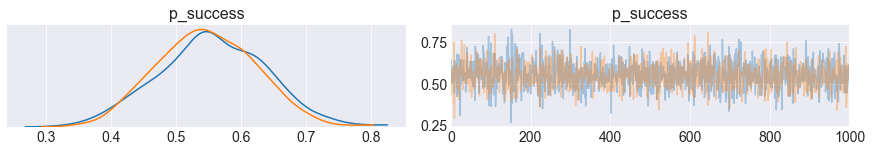

In [40]:
pm.traceplot(trace); #(Theta/Data)

In [41]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p_success,0.55,0.08,0.0,0.39,0.69,2021.12,1.0


We don't belive that this coin is fair 

In [42]:
with pm.Model() as success_model:
    p_success = pm.Uniform('p_success',lower= 0 ,upper = 1) #We are not sure if the coin is fair 
    #p_success= pm.TruncatedNormal('p_success',mu=0.5,sd=0.1,lower=0,upper=1) 
    trials = pm.Bernoulli('trials',p=p_success,observed =TRIALS)

In [43]:
with success_model:

    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(1000, step=step, cores =  1, random_seed = 123)

Sequential sampling (2 chains in 1 job)
Slice: [p_success]
100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:07<00:00, 193.36it/s]


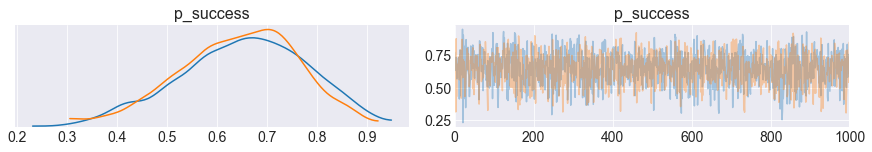

In [44]:
pm.traceplot(trace); #(Theta/Data)

In [45]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p_success,0.65,0.12,0.0,0.41,0.88,1949.59,1.0


In [46]:
revision= pm.trace_to_dataframe(trace)
revision.head()

,p_success
0,0.772796
1,0.662887
2,0.701819
3,0.635186
4,0.732307


# Survey Fish Norway

Uninformative Prior

In [1]:
TRIALS = [6] # 6 de cada 16 contestaron que querian hacer la suscripción por pago por el pescado
#TRIALS = [6,8,5]

In [2]:
6.0/16.0

0.375

In [58]:
with pm.Model() as fish_model:
    p_success = pm.Uniform('p_success',lower= 0 ,upper = 1)
    trials = pm.Binomial('trials',n=16,p=p_success,observed =TRIALS)

In [4]:
with fish_model:

    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(1000, step=step, cores =  1, random_seed = 123)

Sequential sampling (2 chains in 1 job)
Slice: [p_success]
100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:02<00:00, 561.04it/s]


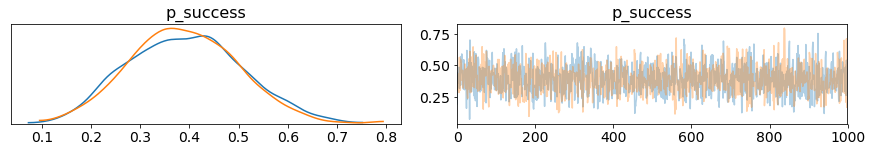

In [5]:
pm.traceplot(trace); #(Theta/Data)

In [6]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p_success,0.39,0.11,0.0,0.18,0.61,1882.72,1.0


Informative Prior

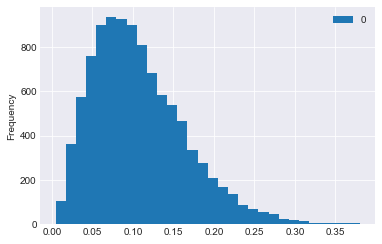

In [65]:
import pandas as pd
pd.DataFrame(np.random.beta(3, 25, size = 9999)).plot(kind = 'hist', bins = 30)

In [69]:
with pm.Model() as fish_model2:
    p_success = pm.Beta('p_success',alpha=3,beta=25)
    trials = pm.Binomial('trials',n=16,p=p_success,observed =TRIALS) #likelihood

In [70]:
with fish_model2:

    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(1000, step=step, cores =  1, random_seed = 123)

Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
Slice: [p_success]
INFO:pymc3:Slice: [p_success]
100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 184.38it/s]


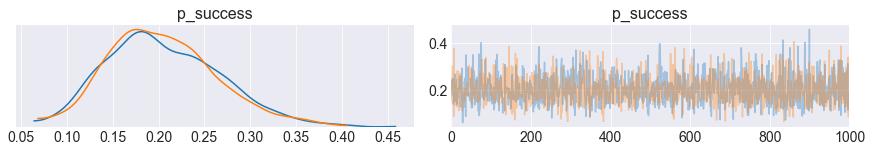

In [71]:
pm.traceplot(trace); #(Theta/Data)

In [72]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p_success,0.21,0.06,0.0,0.1,0.33,2082.87,1.0


# Error of two systems

In [73]:
old_process = [10.4,15.0,9.1,11.8,14.3,13.2,10.7,9.3,9.0,15.2,12.1,12.3,12.6,11.8,11.5,12.3,11.7,12.8,12.8,10.9,10.5]
new_process= [7.1,8.9,5.4,6.8,22.4] #Seems better but with an outlier

In [74]:
y1= np.array(old_process)
y2= np.array(new_process)

In [99]:
old=pd.DataFrame(y1)
new=pd.DataFrame(y2)

In [104]:
old['process']='old'
new['process']='new'
y=pd.concat([old,new],axis=0)

In [106]:
y.columns = ['value','group']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000113A66372E8>,
      dtype=object)

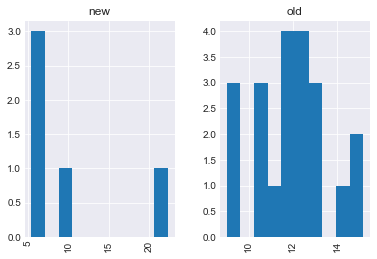

In [107]:
y.hist('value',by='group')

In [110]:
u_m = y.value.mean()
u_s = y.value.std()*2

with pm.Model() as model:
    g1_mean = pm.Normal('g1_mean',u_m,sd=u_s)
    g2_mean = pm.Normal('g2_mean',u_m,sd=u_s)

sigma_low = 1
sigma_high = 10

with model:
    g1_std= pm.Uniform('g1_std',lower= sigma_low, upper= sigma_high)
    g2_std= pm.Uniform('g2_std',lower= sigma_low, upper= sigma_high)

with model:
    v = pm.Exponential('v_minus_one',1/29)+1
with model:
    sd1=g1_std
    sd2=g2_std
    
    old_process= pm.StudentT('old_proccess',nu= v, mu=g1_mean , sd = sd1,observed= y1 )
    new_process= pm.StudentT('new_proccess',nu= v, mu=g2_mean , sd = sd2,observed= y2 )
with model:
    diff_of_means = pm.Deterministic('difference of means',g1_mean- g2_mean)

In [111]:
with model:

    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(1000, step=step, cores =  1, random_seed = 123)

Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
CompoundStep
INFO:pymc3:CompoundStep
>Slice: [v_minus_one]
INFO:pymc3:>Slice: [v_minus_one]
>Slice: [g2_std]
INFO:pymc3:>Slice: [g2_std]
>Slice: [g1_std]
INFO:pymc3:>Slice: [g1_std]
>Slice: [g2_mean]
INFO:pymc3:>Slice: [g2_mean]
>Slice: [g1_mean]
INFO:pymc3:>Slice: [g1_mean]
100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:24<00:00, 11.04it/s]


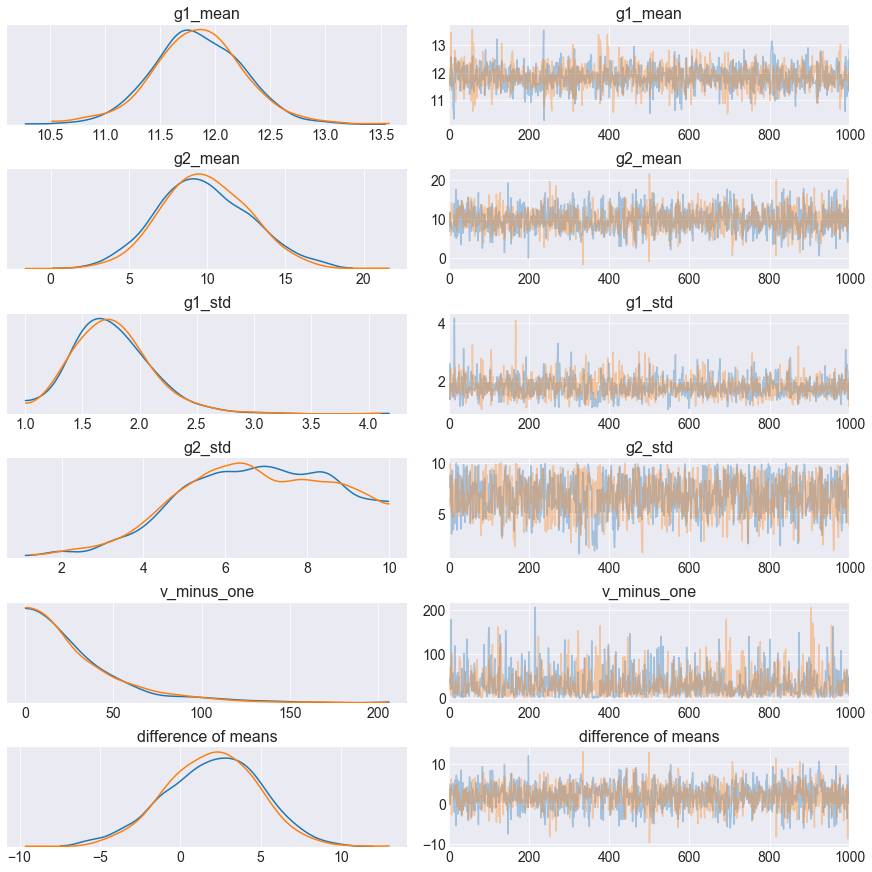

In [112]:
pm.traceplot(trace); #(Theta/Data)

In [113]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
g1_mean,11.85,0.42,0.01,11.01,12.69,1395.73,1.0
g2_mean,9.86,2.96,0.07,4.25,15.71,1619.36,1.0
g1_std,1.77,0.34,0.01,1.09,2.38,1332.29,1.0
g2_std,6.74,1.83,0.05,3.59,10.00,1153.11,1.0
v_minus_one,31.27,29.48,0.80,0.42,93.31,1403.19,1.0
difference of means,1.99,2.98,0.07,-3.86,7.61,1611.32,1.0


In [114]:
revision= pm.trace_to_dataframe(trace)
revision.head()

,g1_mean,g2_mean,g1_std,g2_std,v_minus_one,difference of means
0,11.801289,7.210363,1.889888,8.440851,44.456630,4.590926
1,11.762599,6.905734,1.364013,7.595414,39.153696,4.856865
2,11.539835,11.709052,2.595835,7.700649,34.788219,-0.169217
3,11.840495,8.039019,1.345771,8.824570,37.646508,3.801476
4,12.215092,9.007240,1.620067,6.184486,20.693401,3.207853


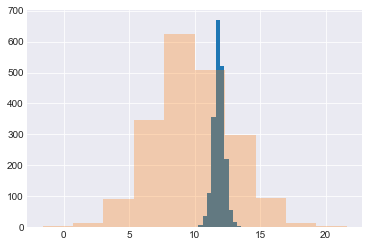

In [118]:
revision.g1_mean.hist()
revision.g2_mean.hist(alpha=0.3)

# Stochastic Volatility

In [10]:
import matplotlib.pyplot as plt

In [8]:
import pandas as pd

returns = pd.read_csv(pm.get_data('SP500.csv'), parse_dates=True, index_col=0)

len(returns)

401

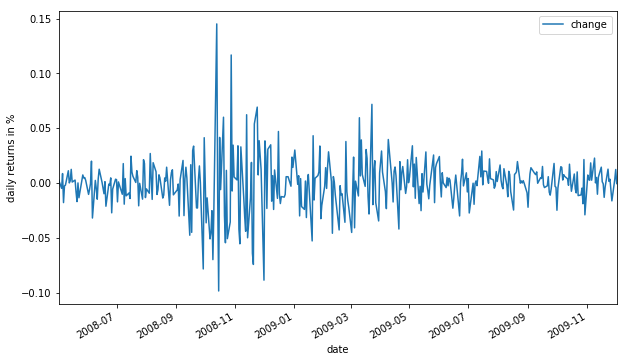

In [11]:
returns.plot(figsize=(10, 6))
plt.ylabel('daily returns in %');

In [15]:
with pm.Model() as sp500_model:
    nu = pm.Exponential('nu', 1/10., testval=5.)
    sigma = pm.Exponential('sigma', 1/0.02, testval=.1)

    s = pm.GaussianRandomWalk('s', sigma=sigma, shape=len(returns))
    volatility_process = pm.Deterministic('volatility_process', pm.math.exp(-2*s)**0.5)

    r = pm.StudentT('r', nu=nu, sigma=volatility_process, observed=returns['change'])

In [16]:
with sp500_model:
    trace = pm.sample(100,cores=1,random_seed = 123)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [s, sigma, nu]
 23%|█████████████████▊                                                            | 137/600 [56:36<3:08:36, 24.44s/it]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [ ]:
pm.traceplot(trace);

# PBI Swtiching Point

In [10]:
import pandas as pd

In [60]:
comercio=pd.read_csv('pbi_comercio.csv')

In [83]:
comercio['PBI'].mean()

3.3333333333333335

In [78]:
inferior = comercio[comercio['PBI']<=3]
superior = comercio[comercio['PBI']>3]

In [79]:
inferior = inferior['PBI'].to_list()
superior = superior['PBI'].to_list()

In [40]:
comercio = comercio['PBI'].to_list()

Inferior

In [80]:
with pm.Model() as comercio_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=0, upper=3)
    #switchpoint = pm.Normal('switchpoint', 3, sd=10)

    # Priors for pre- and post-switch rates number of disasters
    early_pbi = pm.Exponential('early_pbi', 1)
    later_pbi = pm.Exponential('late_pbi', 1)
    
    #early_pbi = pm.Normal('early_pbi',4,sd=10)
    #later_pbi = pm.Normal('late_pbi',4,sd=10)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= inferior, early_pbi, later_pbi)
    

    pbi_posterior = pm.Poisson('pbi_posterior', rate, observed=inferior)

In [81]:
with comercio_model:
    step = pm.Slice()
    trace = pm.sample(1000,cores=1,random_seed = 123)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_pbi, early_pbi]
100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:43<00:00, 34.09it/s]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


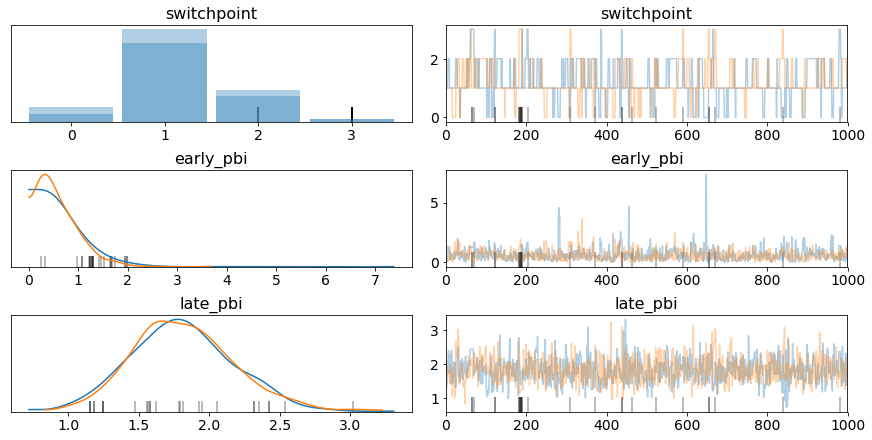

In [82]:
pm.traceplot(trace);

Superior

In [93]:
with pm.Model() as comercio_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=4, upper=7)
    #switchpoint = pm.Normal('switchpoint', 3, sd=10)

    # Priors for pre- and post-switch rates number of disasters
    early_pbi = pm.Exponential('early_pbi', 1)
    later_pbi = pm.Exponential('late_pbi', 1)
    
    #early_pbi = pm.Normal('early_pbi',4,sd=10)
    #later_pbi = pm.Normal('late_pbi',4,sd=10)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= superior, early_pbi, later_pbi)
    
    pbi_posterior = pm.Poisson('pbi_posterior', rate, observed=superior)

In [94]:
with comercio_model:
    step = pm.Slice()
    trace = pm.sample(1000,cores=1,random_seed = 123)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_pbi, early_pbi]
100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:35<00:00, 42.11it/s]
The acceptance probability does not match the target. It is 0.8808692790009333, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


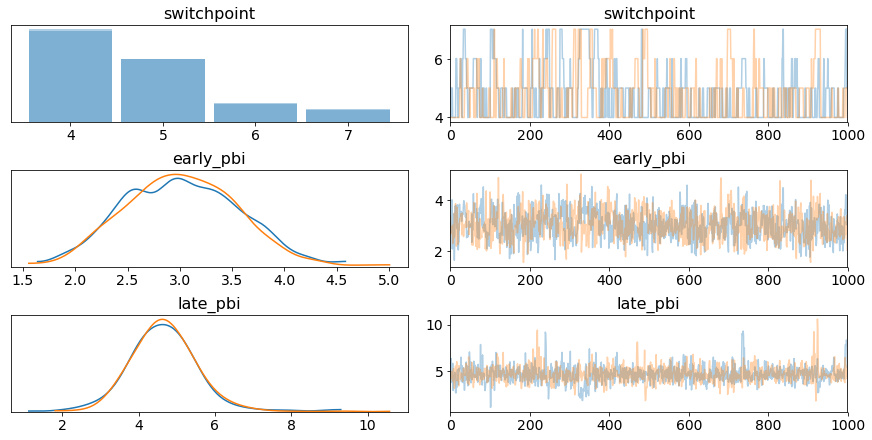

In [95]:
pm.traceplot(trace);

Resultado: El PBI presenta extremos entre 1% y 4%

In [96]:
!start .